# Exercício 2 - Enunciado

2. Um sistema de tráfego  é representado por um grafo orientado ligado. Os nodos denotam pontos de acesso e  os arcos denotam vias de comunicação só com um sentido .  O grafo tem de ser ligado: entre cada par de nodos $\langle n_1,n_2 \rangle$ tem de existir um caminho $n_1 \leadsto n_2$ e um caminho $n_2\leadsto n_1$.
    1. Gerar aleatoriamente o grafo com  $N \in\{8..15\}$  nodos e com ramos verificando:
        1. Cada nodo tem um número aleatório de descendentes $d\in\{0 .. 3\}\,$ cujos destinos são também gerados aleatoriamente. 
        2. Se existirem “loops”  ou destinos repetidos, deve-se gerar outro grafo.
    2. Pretende-se fazer manutenção interrompendo  determinadas vias. Determinar o maior número de vias que é possível remover mantendo o grafo ligado.


# Exercício 2 - Solução

In [5]:
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt
import networkx as nx
import random

Geramos um grafo aleatório fortemente conexo em que cada nodo tem no máximo 3 descendentes

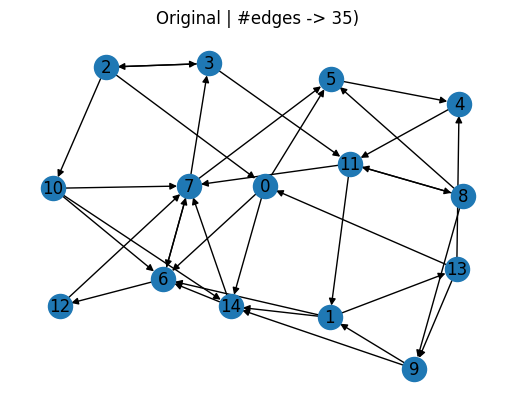

In [6]:
N = 15
max_neighbors = 3
G = nx.DiGraph()
G.add_nodes_from(range(N))
nodes = list(G.nodes())

if max_neighbors == 1:
    random.shuffle(nodes)
    for i in range(N):
        G.add_edge(nodes[i], nodes[(i+1)%N])

while not nx.is_strongly_connected(G):
    G.clear_edges()
    for node in nodes:
        neighbors = set(G.neighbors(node))
        rnd = random.randint(1, max_neighbors)
        rnd = min(rnd, N-1)
        while len(neighbors) < rnd:
            target_node = random.choice(nodes)
            if target_node != node and target_node not in neighbors:
                G.add_edge(node, target_node)
                neighbors.add(target_node)
                
pos = nx.kamada_kawai_layout(G)
plt.title(f'Original | #edges -> {len(G.edges())})')
nx.draw(G, pos, with_labels=True, node_size=300)
plt.show()

Associamos a cada aresta uma variável que pode tomar valores 0 ou 1 em que 1 significa que a aresta foi removida

In [7]:
model = cp_model.CpModel()

edge_vars = {}

for u, v in G.edges():
    edge_vars[u, v] = model.NewIntVar(0, 1, f'edge_{u}_{v}')

Adicionamos uma restrição para garantir que existe pelo menos um caminho entre cada par de nodos em que as arestas desse caminho não são removidas

In [8]:
for i in range(N):
    for j in range(N):
        if i != j:
            paths = nx.all_simple_edge_paths(G, i, j)
            vals = [sum(edge_vars[x] for x in k) for k in paths]
            model.AddMinEquality(0, vals)

Maximizamos o número de arestas removidas e iniciamos o solver

In [9]:
model.Maximize(sum(edge_vars.values()))
            
solver = cp_model.CpSolver()
s = solver.Solve(model)

Removemos as arestas que estão com o valor 1 e temos o resultado

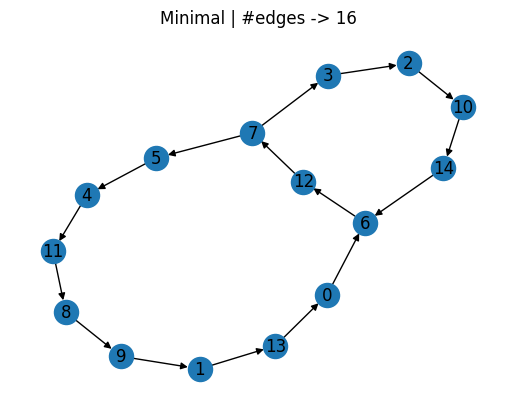

In [10]:
for u, v in edge_vars:
    if solver.Value(edge_vars[u, v]) == 1:
        G.remove_edge(u, v)
        
plt.title(f'Minimal | #edges -> {len(G.edges())}')
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=True, node_size=300)
plt.show()
